# Example with interaction

In this example, we will show how the fundamental global effect methods,  Partial Dependence Plot (PDP) and Accumulated Local Effect (ALE), 
compute the feature effect in the presence of feature interactions. We will use the following model: 

$$ 
f(x_1, x_2, x_3) = -x_1^2 \mathbb{1}_{x_2 <0} + x_1^2 \mathbb{1}_{x_2 \geq 0} + e^{x_3} 
$$

where the features $x_1, x_2, x_3$ are independent and uniformly distributed in the interval $[-1, 1]$.

The model has interaction between $x_1$ and $x_2$, caused by the terms: $f_{1,2}(x_1, x_2) = -x_1^2 \mathbb{1}_{x_2 <0} + x_1^2 \mathbb{1}_{x_2 \geq 0}$.
This means that the effect of $x_1$ depends on the value of $x_2$ and vice versa, 
so there is no golden standard on how to distribute the combined effect to the individual features.
Each method has its own strategy, and below, we show how PDP and ALE treat this interaction.

In contrast, there are no terms that involve interactions between $x_3$ and the other features,
so the effect of $x_3$ can be easily isolated as $e^{x_3}$. 
I
Below, we show how to use the `effector` package to compute the 
Partial Dependence Plot (PDP) and the Accumulated Local Effect (ALE) for the model above.

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import effector

np.random.seed(21)

model = effector.models.ConditionalInteraction()
dataset = effector.datasets.IndependentUniform(dim=3, low=-1, high=1)
x = dataset.generate_data(1_000)

### Partial Dependence Plot (PDP)

Since this is a synthetic example, we know the model $𝑓$ and the data-generating distribution $p(\mathbb{x})$ in closed form, so we can compute the Partial Dependence Plot (PDP) effects based on the PDP definition.
PDP computes the effect of feature $x_s$ as:

$$ PDP(x_s) = \mathbb{E}_{x_{-s}} [f(x_s, x_{-s})] $$

Applying the PDP definition to our case, we have:

$$ 
PDP(x_1) = E_{x_2, x_3} [f(x_1, x_2, x_3)] = 
-x_1^2 E_{x_2}[\mathbb{1}_{x_2 <0}] + x_1^2 E_{x_2}[\mathbb{1}_{x_2 \geq 0}] + E_{x_3}[e^{x_3}]
= -x_1^2 \frac{1}{4} + x_1^2 \frac{1}{4} + 0 = 0 
$$

$$ PDP(x_2) = E_{x_1, x_3} [f(x_1, x_2, x_3)] = 
\mathbb{1}_{x_2 <0} E_{x_1}[-x_1^2] + \mathbb{1}_{x_2 \geq 0} E_{x_1}[x_1^2] + E_{x_3}[e^{x_3}] = 
-\frac{1}{3} \mathbb{1}_{x_2 <0} + \frac{1}{3} \mathbb{1}_{x_2 \geq 0} + c
$$

$$ PDP(x_3) = E_{x_1, x_2} [f(x_1, x_2, x_3)] = e^{x_3} $$

PDP states that $x_1$ has a zero average effect on the model output, $x_2$ has a negative effect of $-\frac{2}{3}$ if $x_2 < 0$ and a positive effect of $\frac{2}{3}$ if $x_2 \geq 0$, and $x_3$ has a positive effect of $e^{x_3}$.
It makes sense: $x_1$ has a zero average effect, since half of the times it has $-x_1^2$ (when $x_2 < 0$) and half of the times it has $x_1^2$ (when $x_2 \geq 0$), so the effects cancel out. 
$x_2$ has a negative effect when $x_2 < 0$ because the term $-x_1^2$ adds a negative value to the model output, and a positive effect when $x_2 \geq 0$ because the term $x_1^2$ adds a positive value to the model output.
Finally, $x_3$, as expected, has an effect of $e^{x_3}$.


In real-world scenarios, we do not know the data-generating distribution $p(\mathbf{x})$ or the model $f$ in closed form.
We simply have a dataset $X$, a `np.ndarray` of shape `(n_samples, n_features)`, drawn from an unknown distribution, 
a black-box model $f$, a `Python` function, and 
`effector` which can approximate the PDP effects based on the dataset $X$ and the model $f$.
Let's see that in practice.


In [59]:
def compute_centering_constant(func, start, stop, nof_points):
    x = np.linspace(start, stop, nof_points)
    y = func(x)
    return np.mean(y)
    

In [60]:
def pdp_ground_truth(feature, xs):
    if feature == 0:
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 1:
        ff = lambda x: -1/3 * (x < 0) + 1/3 * (x >= 0)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 2:
        ff = lambda x: np.exp(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z

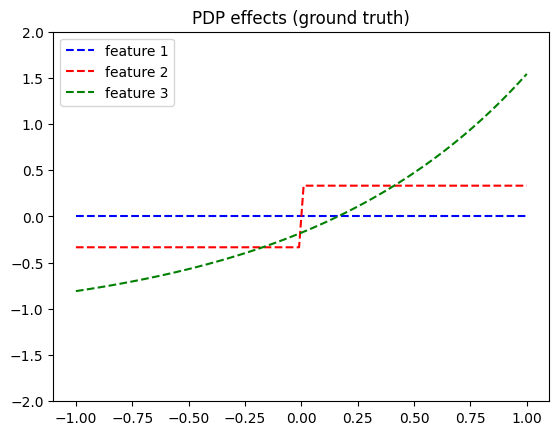

In [61]:
xx = np.linspace(-1, 1, 100)
y_pdp = []
for feature in [0, 1, 2]:
    y_pdp.append(pdp_ground_truth(feature, xx))

plt.figure()
plt.title("PDP effects (ground truth)")
color_pallette = ["blue", "red", "green"]
for feature in [0, 1, 2]:
    plt.plot(
        xx, 
        y_pdp[feature], 
        color=color_pallette[feature], 
        linestyle="--",
        label=f"feature {feature + 1}"
    )
plt.legend()
plt.xlim([-1.1, 1.1])
plt.ylim([-2, 2])
plt.show()
    
    

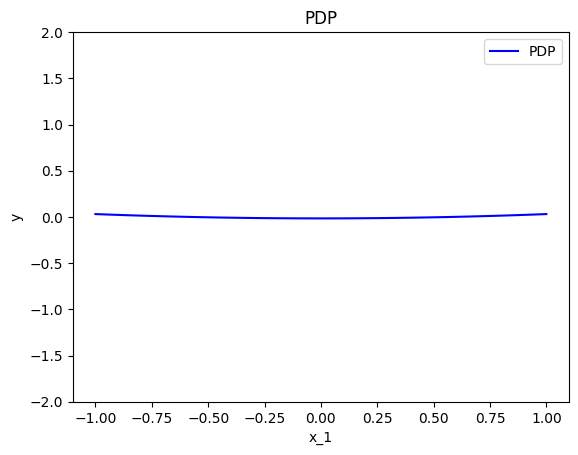

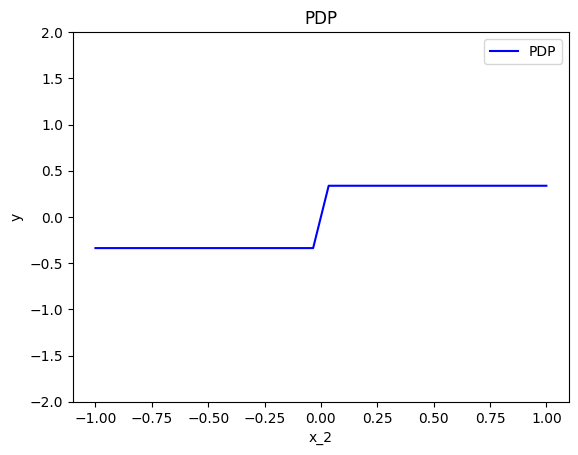

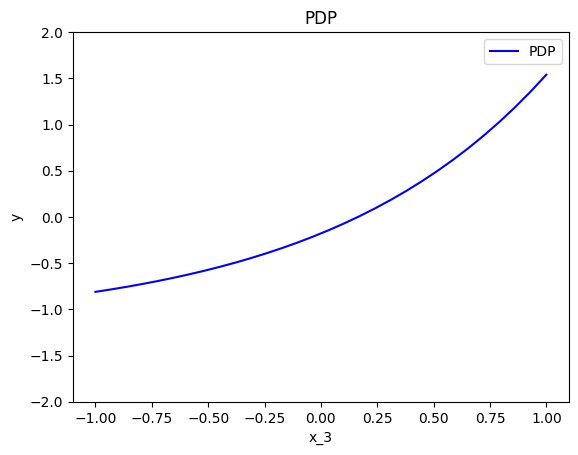

In [62]:
pdp = effector.PDP(x, model.predict, dataset.axis_limits)
pdp.fit(features="all", centering=True)
for feature in [0, 1, 2]:
    pdp.plot(feature=feature, centering=True, y_limits=[-2, 2])

In [63]:
# make a test
xx = np.linspace(-1, 1, 100)
for feature in [0, 1, 2]:
    y_pdp = pdp.eval(feature=feature, xs=xx, centering=True)
    y_gt = pdp_ground_truth(feature, xx)
    np.testing.assert_allclose(y_pdp, y_gt, atol=1e-1)

### Accumulated Local Effect (ALE)

Accumulated Local Effect (ALE) is another method to compute the global effect of a feature on the model output. Its formula is:

$$ ALE(x_s) = \int_{x_{s,min}}^{x_s} \mathbb{E}_{x_{-s}|z} \left [ \frac{\partial f}{\partial x_s} (z, x_{-s}) \right ] dz $$
$$

Observe that ALE uses the derivative of the model $f$ with respect to the feature $x_s$. Therefore, we need a differentiable black-box function to define the ALE effect. In our case, the indicator terms are not differentiable at $x_2 = 0$, so we need some strategy to handle this issue.
Applying the definition of ALE to our model, we have:

$$ALE(x_1) = 0$$
$$ALE(x_2) = \cases{ 0 \text{ if } x_2 < 0 \\ \text{undefined if } x_2 \geq 0}$$
$$ALE(x_3) = e^{x_3}$$

Below we provide the proofs:

$$ 
ALE(x_1) = \int_{x_{1,min}}^{x_1} \mathbb{E}_{x_2, x_3|x_1} \frac{\partial f}{\partial x_1} (z, x_2, x_3) dz
= \int_{x_{1,min}}^{x_1} \mathbb{E}_{x_2, x_3|x_1} \left( -2z \mathbb{1}_{x_2 <0} + 2z \mathbb{1}_{x_2 \geq 0} \right) dz 
= \int_{x_{1,min}}^{x_1} \left( -2z \frac{1}{4} + 2z \frac{1}{4} \right) dz = 0
$$

$$ ALE(x_2) = \int_{x_{2,min}}^{x_2} \mathbb{E}_{x_1, x_3|x_2} \frac{\partial f}{\partial x_2} (x_1, z, x_3) dz
= \int_{x_{2,min}}^{x_2} \mathbb{E}_{x_1, x_3|x_2} \left( -x_1^2 \frac{d \mathbb{1}_{x_2<0}}{dx_2} + x_1^2 \frac{d \mathbb{1}_{x_2 \geq 0}}{dx_2} \right) dz
\propto \cases{ 0 \text{ if } x_2 < 0 \\ \text{undefined if } x_2 \geq 0}
$$

$$ ALE(x_3) = \int_{x_{3,min}}^{x_3} \mathbb{E}_{x_1, x_2|x_3} \frac{\partial f}{\partial x_3} (x_1, x_2, z) dz
= \int_{x_{3,min}}^{x_3} \mathbb{E}_{x_1, x_2|x_3} e^z dz \propto e^{x_3}
$$

ALE states the same as PDP for $x_1$ and $x_3$: $x_1$ average effect is zero and $x_3$ has an effect of $e^{x_3}$.

For $x_2$, ALE is zero if $x_2 < 0$ and undefined if $x_2 \geq 0$.
In fact, ALE says that the derivative effect is zero for $x_2 < 0$, zero for $x_2 > 0$, and undefined at $x_2 = 0$. But since the final effect is 
an integral of the derivative, the non-differentiability at $x_2 = 0$ affects all the points $x_2 \geq 0$.

We will see below that there are two different approaches to handle this issue: ALE and RHALE. These are two approximations of the ALE definition, and they have different strategies to handle the non-differentiability issue. 


## ALE approximation

ALE approximation creates a piecewise linear function to approximate ALE definition:

$$\hat{\text{ALE}}(x_s) = \sum_{k=1}^{k_{x_s}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ f(z_k, x_c) - f(z_{k-1}, x_c) \right ]
$$

$\hat{\text{ALE}}(x_s)$ uses a Riemannian sum to approximate the integral of $\text{ALE}(x_s)$. The axis of the $s$-th feature is split in $K$ bins (intervals) of equal size. In each bin, the average effect is estimated by the difference between the model output at the right and left bin edges. 

Therefore, for $x_2$, ALE approximation will compute a negative effect of $-\frac{1}{3}$ if $x_2 < -\frac{1}{K}$, a positive effect of $\frac{1}{3}$ if $x_2 > \frac{1}{K}$ and a linear transition in between.


In [64]:
def ale_ground_truth(feature, xs):
    if feature == 0:
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 1:
        K = 51
        ff = lambda x: -1/3 * (x < 0) + 1/3 * (x >= 0)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 2:
        ff = lambda x: np.exp(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z

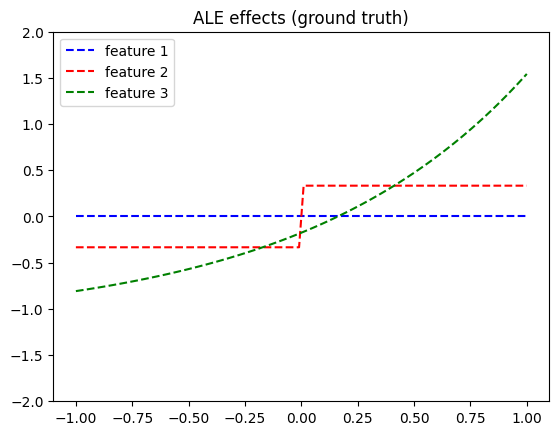

In [65]:
xx = np.linspace(-1, 1, 100)
y_ale = []
for feature in [0, 1, 2]:
    y_ale.append(ale_ground_truth(feature, xx))
    
plt.figure()
plt.title("ALE effects (ground truth)")
color_pallette = ["blue", "red", "green"]
for feature in [0, 1, 2]:
    plt.plot(
        xx, 
        y_ale[feature], 
        color=color_pallette[feature], 
        linestyle="--",
        label=f"feature {feature + 1}"
    )
plt.legend()
plt.xlim([-1.1, 1.1])
plt.ylim([-2, 2])
plt.show()
    

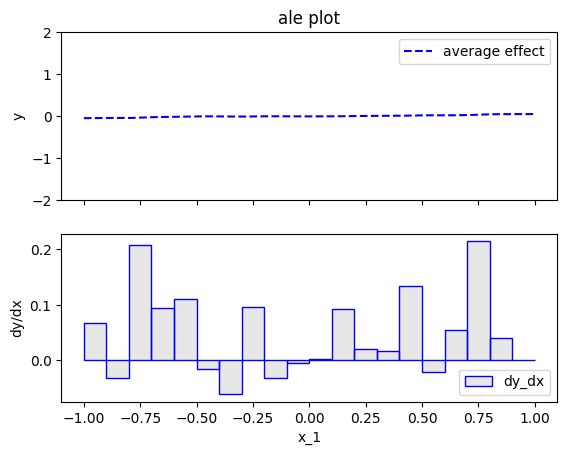

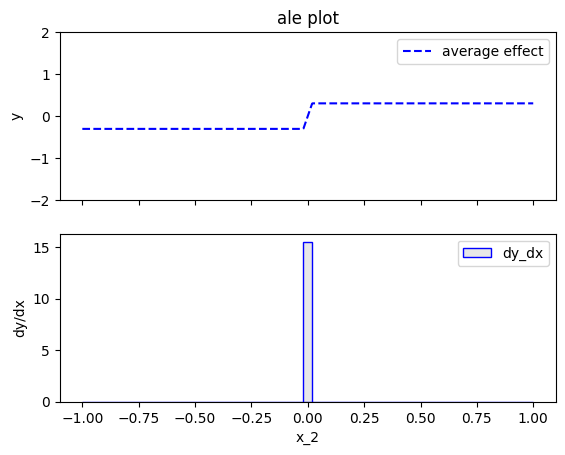

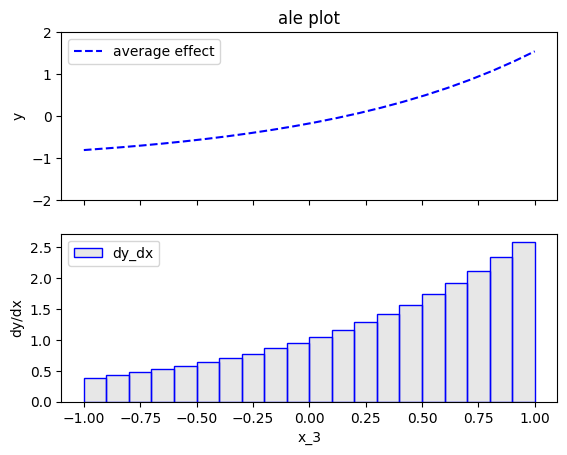

In [66]:
ale = effector.ALE(x, model.predict, axis_limits=dataset.axis_limits)
ale.fit(features=1, centering=True, binning_method=effector.binning_methods.Fixed(nof_bins=51))

for feature in [0, 1, 2]:
    ale.plot(feature=feature, centering=True, y_limits=[-2, 2])

In [67]:
xx = np.linspace(-1, 1, 100)
for feature in [1]:# [0, 1, 2]:
    y_ale = ale.eval(feature=feature, xs=xx, centering=True)
    y_gt = ale_ground_truth(feature, xx)
    
    # hack to remove the effect at undefined region
    if feature == 1:
        K = 51
        ind = np.logical_and(xx > -1/K, xx < 1/K)
        y_ale[ind] = 0
        y_gt[ind] = 0
    
    np.testing.assert_allclose(y_ale, y_gt, atol=1e-1)
    

### Robust and Heterogeneity-aware ALE (RHALE)

RHALE, in contrast to ALE, approximates the effect with derivatives at the instances, instead of the bin edges.

$$\hat{\text{RHALE}}(x_s) = \sum_{k=1}^{k_{x_s}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ \frac{\partial f}{\partial x_s} (z_i, x_c) \right ]
 $$

Therefore, it computes a zero effect everywhere.


In [68]:
def rhale_ground_truth(feature, xs):
    if feature == 0:
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 1:
        K = 51
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 2:
        ff = lambda x: np.exp(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z


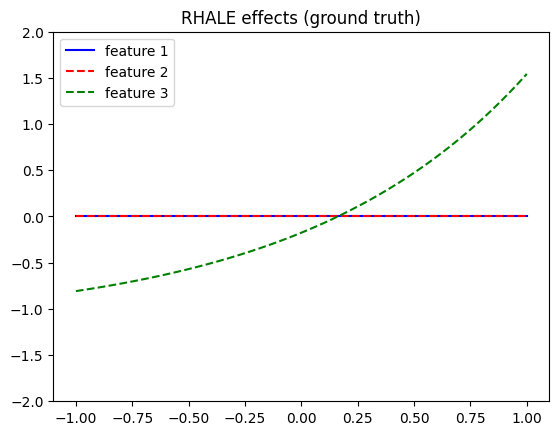

In [69]:
xx = np.linspace(-1, 1, 100)
y_rhale = []
for feature in [0, 1, 2]:
    y_rhale.append(rhale_ground_truth(feature, xx))
    
plt.figure()
plt.title("RHALE effects (ground truth)")
color_pallette = ["blue", "red", "green"]
for feature in [0, 1, 2]:
    plt.plot(
        xx, 
        y_rhale[feature], 
        color=color_pallette[feature], 
        linestyle="-" if feature == 0 else "--",
        label=f"feature {feature + 1}"
    )
plt.legend()
plt.xlim([-1.1, 1.1])
plt.ylim([-2, 2])
plt.show()



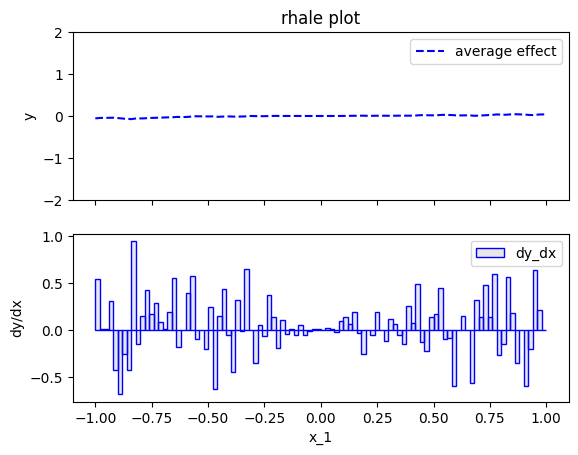

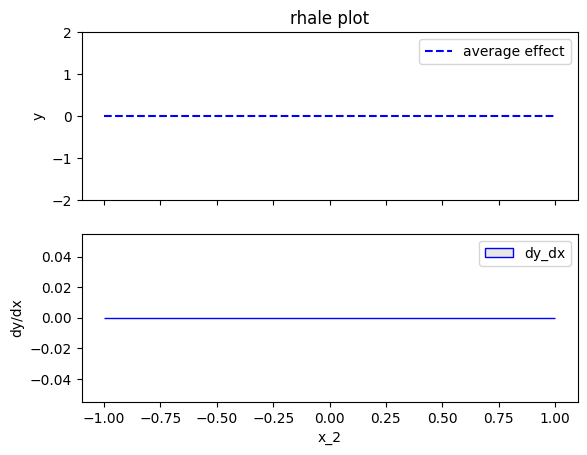

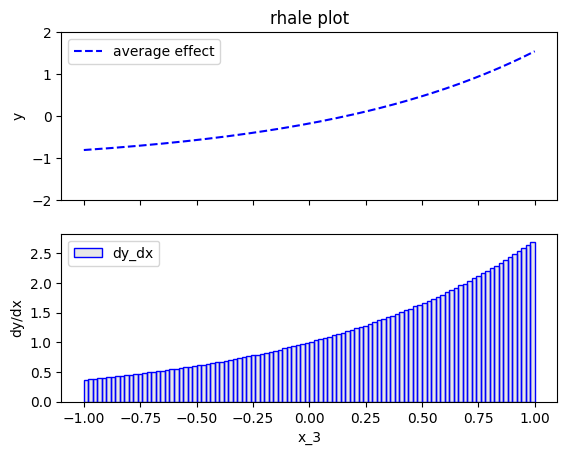

In [70]:
rhale = effector.RHALE(x,
                       model.predict,
                       model.jacobian,
                       axis_limits=dataset.axis_limits
                       )
rhale.fit(features="all", centering=True)

for feature in [0, 1, 2]:
    rhale.plot(feature=feature, centering=True, y_limits=[-2, 2])
    

In [71]:
for feature in [0, 1, 2]:
    y_ale = rhale.eval(feature=feature, xs=xx, centering=True)
    y_gt = rhale_ground_truth(feature, xx)
    np.testing.assert_allclose(y_ale, y_gt, atol=1e-1)